In [2]:
# Libraries 
# -----------------------------------------------------------------------
import pandas as pd
import numpy as np
import re

from itertools import combinations
from scipy.stats import kstest, spearmanr, pearsonr, chi2_contingency

# Configuration
# -----------------------------------------------------------------------
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
# pd.set_option('display.max_rows', None)

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('data/df_final.csv', index_col=0)

In [4]:
df.head()

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,adr_category,total_nights,arrival_date
hotel,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Resort Hotel,False,342.0,2015.0,7.0,27.0,1.0,0.0,0.0,2.0,NaN,0.0,BB,PRT,Direct,Direct,0.0,NaN,0.0,C,C,3.0,0.0,NaN,0.0,Transient,0.0,0.0,0.0,Check-Out,2015-07-01,Grátis,0.0,2015-07-01
Resort Hotel,False,737.0,2015.0,7.0,27.0,1.0,0.0,0.0,2.0,NaN,0.0,BB,NaN,Direct,Direct,0.0,0.0,0.0,NaN,C,4.0,0.0,NaN,0.0,Transient,0.0,0.0,0.0,Check-Out,2015-07-01,Grátis,0.0,2015-07-01
Resort Hotel,False,7.0,2015.0,7.0,27.0,1.0,0.0,1.0,1.0,0.0,0.0,BB,GBR,Direct,Direct,0.0,0.0,0.0,A,C,0.0,0.0,NaN,0.0,Transient,75.0,0.0,0.0,Check-Out,2015-07-02,Medio-bajo,1.0,2015-07-01
Resort Hotel,False,13.0,2015.0,7.0,27.0,1.0,0.0,1.0,1.0,NaN,0.0,BB,GBR,Corporate,Corporate,0.0,0.0,0.0,A,A,0.0,304.0,NaN,0.0,Transient,75.0,0.0,0.0,Check-Out,2015-07-02,Medio-bajo,1.0,2015-07-01
Resort Hotel,False,14.0,2015.0,7.0,27.0,1.0,0.0,2.0,2.0,NaN,0.0,BB,NaN,Online TA,TA/TO,0.0,0.0,0.0,A,A,0.0,240.0,NaN,0.0,Transient,98.0,0.0,1.0,Check-Out,2015-07-03,Medio-bajo,2.0,2015-07-01


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 117816 entries, Resort Hotel to City Hotel
Data columns (total 33 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   is_canceled                     117816 non-null  bool   
 1   lead_time                       117816 non-null  float64
 2   arrival_date_year               111887 non-null  float64
 3   arrival_date_month              117816 non-null  float64
 4   arrival_date_week_number        116888 non-null  float64
 5   arrival_date_day_of_month       117816 non-null  float64
 6   stays_in_weekend_nights         117816 non-null  float64
 7   stays_in_week_nights            117816 non-null  float64
 8   adults                          117816 non-null  float64
 9   children                        68254 non-null   float64
 10  babies                          117816 non-null  float64
 11  meal                            117816 non-null  object 
 12  countr

In [20]:
def categorize_season(month):
    if month in [6, 7, 8]:
        return 'Verano'
    elif month in [12, 1, 2]:
        return 'Invierno'
    else:
        return None  # Devuelve None para las otras estaciones


df['season'] = df['arrival_date_month'].apply(lambda x: categorize_season(int(x)))

# Filtrar las filas donde 'season' no es None (solo verano e invierno)
df = df[df['season'].notna()]


In [21]:
# Crear una columna para diferenciar entre semana y fines de semana
def categorize_day_of_week(row):
    if row['stays_in_weekend_nights'] > 0:
        return 'Fin de semana'
    else:
        return 'Entre semana'

df['week_period'] = df.apply(categorize_day_of_week, axis=1)


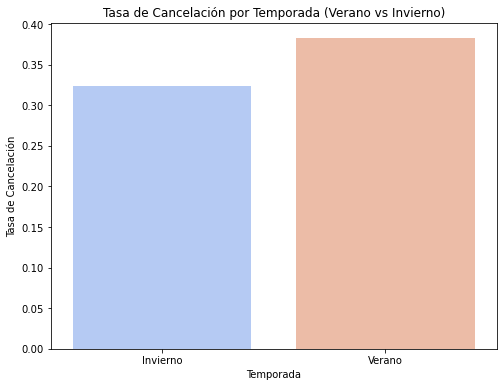

In [22]:
# Crear una tabla para calcular la tasa de cancelación por temporada
season_cancel_rate = df.groupby('season')['is_canceled'].mean().reset_index()

# Graficar la tasa de cancelación por temporada
plt.figure(figsize=(8, 6))
sns.barplot(data=season_cancel_rate, x='season', y='is_canceled', palette='coolwarm')
plt.title('Tasa de Cancelación por Temporada (Verano vs Invierno)')
plt.ylabel('Tasa de Cancelación')
plt.xlabel('Temporada')
plt.show()


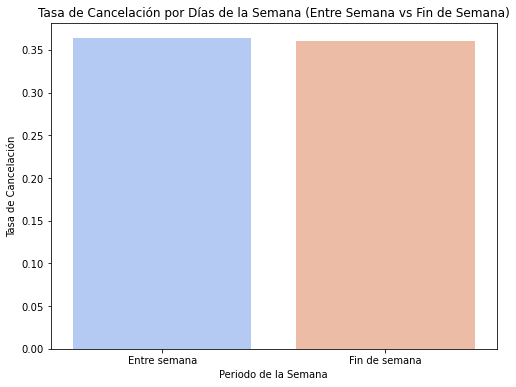

In [23]:
# Crear una tabla para calcular la tasa de cancelación por días de la semana
week_cancel_rate = df.groupby('week_period')['is_canceled'].mean().reset_index()

# Graficar la tasa de cancelación entre semana vs fines de semana
plt.figure(figsize=(8, 6))
sns.barplot(data=week_cancel_rate, x='week_period', y='is_canceled', palette='coolwarm')
plt.title('Tasa de Cancelación por Días de la Semana (Entre Semana vs Fin de Semana)')
plt.ylabel('Tasa de Cancelación')
plt.xlabel('Periodo de la Semana')
plt.show()


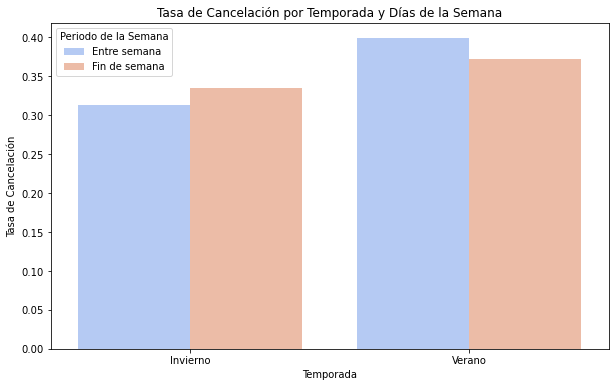

In [24]:
# Crear una tabla para calcular la tasa de cancelación por temporada y días de la semana
season_week_cancel_rate = df.groupby(['season', 'week_period'])['is_canceled'].mean().reset_index()

# Graficar la tasa de cancelación por temporada y días de la semana
plt.figure(figsize=(10, 6))
sns.barplot(data=season_week_cancel_rate, x='season', y='is_canceled', hue='week_period', palette='coolwarm')
plt.title('Tasa de Cancelación por Temporada y Días de la Semana')
plt.ylabel('Tasa de Cancelación')
plt.xlabel('Temporada')
plt.legend(title='Periodo de la Semana')
plt.show()


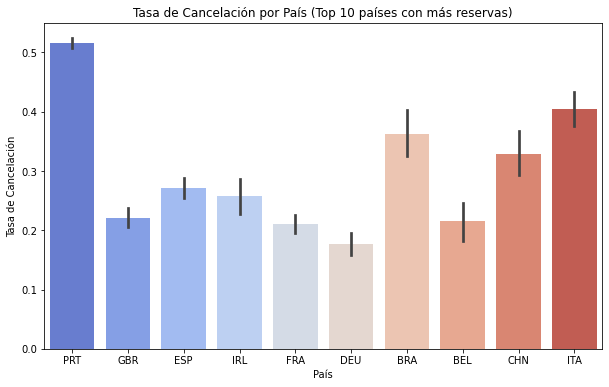

In [25]:
# Crear una tabla con la tasa de cancelación por país
country_cancel_rate = df.groupby('country')['is_canceled'].mean().reset_index()

# Graficar la tasa de cancelación por país (solo los países con más de 100 reservas para claridad)
top_countries = df['country'].value_counts().nlargest(10).index  # Tomar los 10 países con más reservas
filtered_data = df[df['country'].isin(top_countries)]

plt.figure(figsize=(10, 6))
sns.barplot(data=filtered_data, x='country', y='is_canceled', palette='coolwarm')
plt.title('Tasa de Cancelación por País (Top 10 países con más reservas)')
plt.ylabel('Tasa de Cancelación')
plt.xlabel('País')
plt.show()


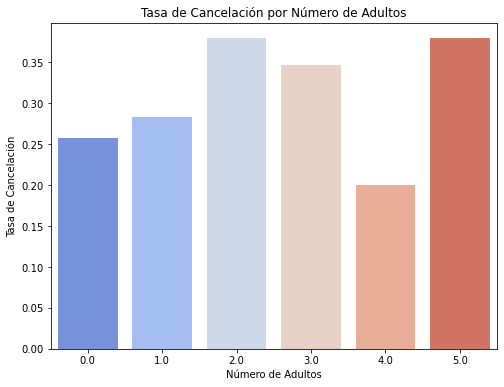

In [26]:
# Crear una tabla con la tasa de cancelación por número de adultos
adults_cancel_rate = df.groupby('adults')['is_canceled'].mean().reset_index()

# Graficar la tasa de cancelación por número de adultos
plt.figure(figsize=(8, 6))
sns.barplot(data=adults_cancel_rate, x='adults', y='is_canceled', palette='coolwarm')
plt.title('Tasa de Cancelación por Número de Adultos')
plt.ylabel('Tasa de Cancelación')
plt.xlabel('Número de Adultos')
plt.show()


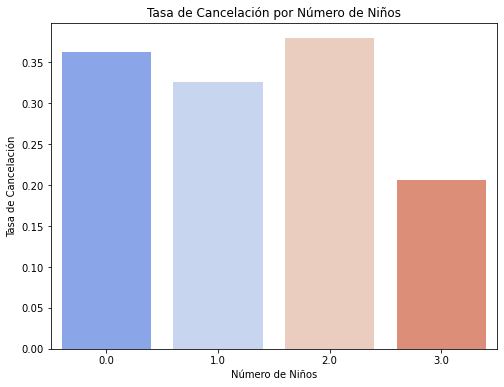

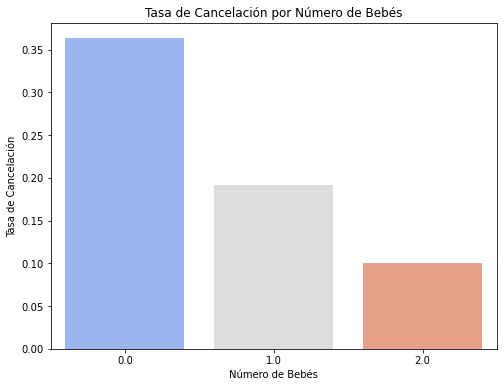

In [27]:
# Tasa de cancelación por número de niños
children_cancel_rate = df.groupby('children')['is_canceled'].mean().reset_index()

plt.figure(figsize=(8, 6))
sns.barplot(data=children_cancel_rate, x='children', y='is_canceled', palette='coolwarm')
plt.title('Tasa de Cancelación por Número de Niños')
plt.ylabel('Tasa de Cancelación')
plt.xlabel('Número de Niños')
plt.show()

# Tasa de cancelación por número de bebés
babies_cancel_rate = df.groupby('babies')['is_canceled'].mean().reset_index()

plt.figure(figsize=(8, 6))
sns.barplot(data=babies_cancel_rate, x='babies', y='is_canceled', palette='coolwarm')
plt.title('Tasa de Cancelación por Número de Bebés')
plt.ylabel('Tasa de Cancelación')
plt.xlabel('Número de Bebés')
plt.show()


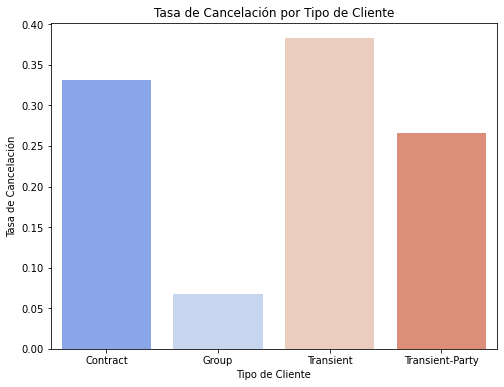

In [28]:
# Crear una tabla con la tasa de cancelación por tipo de cliente
customer_type_cancel_rate = df.groupby('customer_type')['is_canceled'].mean().reset_index()

# Graficar la tasa de cancelación por tipo de cliente
plt.figure(figsize=(8, 6))
sns.barplot(data=customer_type_cancel_rate, x='customer_type', y='is_canceled', palette='coolwarm')
plt.title('Tasa de Cancelación por Tipo de Cliente')
plt.ylabel('Tasa de Cancelación')
plt.xlabel('Tipo de Cliente')
plt.show()
